# Validation of the PyPSA-Africa network for Kazakhstan (Central Asia)

This notebooks investigates the results obtained by pypsa-africa model for the Central Asia case, in particular for Kazakhstan. Public information of the power system of Central Asia' countries are compared to those used and obtained from the pypsa-africa model. Looking at Kazakhstan (Central Asia) only, we further compare the data to official data, which you can find in:
1. Global Energy Network Institute for Central Asia (http://www.geni.org/globalenergy/library/national_energy_grid/index.shtml)
2. Kazakhstan electricity grid operating company (https://www.kegoc.kz/ru/about/natsionalnaya-energosistema/)

The following quantities will be reviewed:
- inputs used by the pypsa-model:
  - network characteristics, length
  - substations
  - installed generation by type
  - voltage classes
- outputs of the simulation:
  - network topography

To properly reproduce the findings obtained in this notebook, please run the full snakemake procedure only for the case of Kazakhstan. To do so, please set countries = ["KZ"] in the `config.yaml file`.


At the next stage, it is necessary to carry out similar stages for the whole of Central Asia ["CASR"] in order to identify shortcomings.

## Preparation

### Definition of main folder paths

In [1]:
import os

# OSM raw data files
substations_OSMraw_path = os.getcwd() + "/resources/osm/raw/KZ_all_raw_substations.geojson"
lines_OSMraw_path = os.getcwd() + "/resources/osm/raw/KZ_all_raw_lines.geojson"
substations_OSMraw_path2 = os.getcwd() + "/resources/osm/raw/CASR_all_raw_substations.geojson"
lines_OSMraw_path2 = os.getcwd() + "/resources/osm/raw/CASR_all_raw_lines.geojson"

# cleaned osm data files
substations_OSMclean_path = os.getcwd() + "/resources/osm/clean/KZ_all_substations.geojson"
lines_OSMclean_path = os.getcwd() + "/resources/osm/clean/KZ_all_lines.geojson"
substations_OSMclean_path2 = os.getcwd() + "/resources/osm/clean/CASR_all_substations.geojson"
lines_OSMclean_path2 = os.getcwd() + "/resources/osm/clean/CASR_all_lines.geojson"

# shapes files
countries_shape_path = os.getcwd() + "/resources/shapes/KZ_country_shapes.geojson"
countries_shape_path2 = os.getcwd() + "/resources/shapes/CASR_country_shapes.geojson"

# solve network output
solved_network_path = os.getcwd() + "/results/networks/elec_s_100_ec_lcopt_Co2L-3H.nc"

### Import packages

In [2]:
# import packages

import logging

import pypsa

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import geoplot
import pandas as pd
import numpy as np
import hvplot.pandas

import scipy as sp
import networkx as nx
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

# import fiona  # ;help(fiona.open)
# import requests
from pandas.io.json import json_normalize  # convert json into dataframe

import shapely, shapely.prepared
from shapely.geometry import Point, LineString
from shapely.wkt import loads
from shapely.validation import make_valid
from pyproj import Geod  # to calculate length globally "Geodesic calculations"

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

### Set main directory to root folder

In [3]:
# set current folders
import sys

sys.path.append("../../")  # adds path to $ .../pypsa-africa
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")  # moves path to root

This is the repository path:  D:\Github\pypsa-africa
Had to go 0 folder(s) up.


## 1. Analysis of network for Kazakhstan and the Central Asia case

In this subsection, the data publicy on the network power system are compared. In particular, the main data that are being compared are:
- Layout of the network as shown by images (Section 1, 4)
- Total length of the line (Section 1, 3)

The data used for the comparison have been taken from public reliable sources, with strong focus on the website of the 
Kazakhstan Electricity Grid Operating Company ([KEGOC](https://www.kegoc.kz/ru/about/natsionalnaya-energosistema/)) and data of Global Energy Network Institute ([GENI](http://www.geni.org/globalenergy/library/national_energy_grid/index.shtml)).
This is the most complete and up-to-date open maps of Central Asia's electricity grid network.

In the Section 1, the network layout obtained by the public website. The image below, dated 2016, available from Global Energy Network Institute for Central Asia, depicts the national power grid of Central Asia, which includes Kazakhstan, Kyrgyzstan, Tajikistan, Turkmenistan, Uzbekistan and Afghanistan. The data for Kazakhstan from KEGOC is dated 2022.

[Source link](http://www.geni.org/globalenergy/library/national_energy_grid/central-asia/graphics/central-asia-electricity-grid.gif) - Map of Central Asian electricity Grid

![Schematic map of electrical networks 1150-500-220-110 kV UPS of the Republic of Kazakhstan as of 01.01.2022](CASR.png)
[Source link](https://www.kegoc.kz/upload/iblock/e2f/s9m8xjeia620dr16qo94dxn5lisd4rso.pdf)


In the Section 3, the network length as obtained from the workflow is calculated to then be compared with the information reported by:
1. The Kazakhstan Electricity Grid Operating Company ([KEGOC](https://www.kegoc.kz/ru/about/))

In Kazakhstan, there are (by circuits of line):

- \> 26824 km lines, including:
        - 1150 kV OHTL – 1421.225 km
        - 500 kV OHTL – 8287.977 km
        - 330 kV OHTL – 1863.28 km
        - 220 kV OHTL – 14898.858 km
        - 110 kV OHTL – 352.841 km
        - 35 kV OHTL – 44.13 km
        - 10 kV OHTL – 111.171 km
        - 6 kV OHTL – 12.851 km
        - 0.4 kV OHTL – 5.59 km 
- \> 38723 MW line capacity, including:
        - 1150 kV - 9384.1 MVA
        - 500 kV - 17447.5 MVA
        - 220 kV - 11891.25 MVA
        - 35 kV - 23.2 MVA

These information shall be close to those obtained by the workflow.

## 2. Load data 




#### World Bank Data

Note: This dataset has been updated with transmission lines for Kazakhstan. This is the most complete and up-to-date open map of Kazakhstan's electricity grid network. This dataset is the most detail at the time of 2016 ([WBD](https://energydata.info/dataset/kazakhstan-electricity-transmission-network-2016)). 

Coverage.  Data collected and prepared from the Kazakhstan’s National Transmission Grid map. This dataset includes planned and existing grid lines for Kazakhstan. Includes transmission lines, substations, as well as power stations. The lines range in voltage from 220 kV to 1150 kV EHV lines.

Limitations. Some of the data, notably that from World Bank project archives, may be very out of date. Where possible this has been improved with data from other sources, in particular from  KEGOC.

Thus, many new lines may exist which aren't shown, and planned lines may have completely changed or already been constructed.  The network map for Kazakhstan from KEGOC is the most complete to represent existing and under construction networks.
The data that comes from World Bank project archives has been digitized from PDF maps. This means that these lines should serve as an indication of extent and general location, but shouldn't be used for precisely location grid lines.

In the case of Kazakhstan, data on existing and planned lines is presented in different .geojson files and with text information in the columns of the table. Therefore, it is suggested to download the .geojson format files of existing lines in main folder `(/pypsa-africa)` from the link and run the following conversion:

In [43]:
url = "https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/145212/lines-existing_0.geojson"

df_lines_world_bank_existing = gpd.read_file(url).to_crs(epsg=3857)
df_lines_world_bank_existing.rename(columns={"#LayerName": "voltage_kV"}, errors="raise", inplace=True)
df_lines_world_bank_existing.rename(columns={"#Length": "length"}, errors="raise", inplace=True)
df1 = df_lines_world_bank_existing.replace(to_replace="1150 kV Lines-EXISTING",value="1150")
df2 = df1.replace(to_replace="500 kV Lines-EXISTING",value="500")
df3 = df2.replace(to_replace="220 kV Lines-EXISTING",value="220")

df_lines_world_bank_existing = df3.drop(['#Opacity', '#Component', '#Id', '#Name', '#VertexCou', '#Style', '#StrokeWei', '#PathClose', '#ArtScale'], axis=1)
print(df_lines_world_bank_existing.head(5))

#df_lines_world_bank_existing_path = os.getcwd() + "/resources/KZ_existing.geojson"
#df_lines_world_bank_existing = gpd.read_file(df_lines_world_bank_existing_path).to_crs(epsg=3857)

  voltage_kV         length  \
0       1150  292589.161079   
1       1150  400853.103912   
2       1150  335541.740390   
3       1150  315134.928040   
4        220   30908.309648   

                                                                geometry  
0  LINESTRING (8385425.232 6843812.039, 8399501.473 6951241.711, 8770...  
1  LINESTRING (7737386.870 7024644.091, 8132952.038 6971674.872, 8366...  
2  LINESTRING (7142464.194 6984390.596, 7225184.876 7029527.561, 7416...  
3  LINESTRING (6753886.602 7359818.984, 6846723.810 7346285.309, 7112...  
4  LINESTRING (8568668.122 5381679.050, 8549391.175 5389840.149, 8548...  


#### Raw Open Street Map Data for Kazakhstan
Created by our python script `download_osm_data.py`. Generate this data by running the pypsa-africa workflow through `snakemake -j1 download_osm_data` (see Snakefile if run fails)

In [44]:
# substations
substations_OSMraw_path = os.getcwd() + "/resources/osm/raw/KZ_all_raw_substations.geojson"
df_substations_raw_osm_KZ = gpd.read_file(substations_OSMraw_path).to_crs(epsg=3857)

# lines
lines_OSMraw_path = os.getcwd() + "/resources/osm/raw/KZ_all_raw_lines.geojson"
df_lines_raw_osm_KZ = gpd.read_file(lines_OSMraw_path).to_crs(epsg=3857)

# lines by circuits
#df_lines_raw_osm_KZ_circuits = df_lines_clean_osm_KZ.replace({'circuits': 2}, {'circuits': 1}, regex=True)

#### Cleaned Open Street Map Data for Kazakhstan
Created by our python script `clean_osm_data.py`. Generate this data by running the pypsa-africa workflow through `snakemake -j1 clean_osm_data` (see Snakefile if run fails)

In [6]:
# substations
substations_OSMclean_path = os.getcwd() + "/resources/osm/clean/KZ_all_substations.geojson"
df_substations_clean_osm_KZ = gpd.read_file(substations_OSMclean_path)
df_substations_clean_osm_KZ["geometry"] = (
    df_substations_clean_osm_KZ["geometry"].apply(make_valid).to_crs(epsg=3857)
)

# lines
lines_OSMclean_path = os.getcwd() + "/resources/osm/clean/KZ_all_lines.geojson"
df_lines_clean_osm_KZ = gpd.read_file(lines_OSMclean_path)
df_lines_clean_osm_KZ["geometry"] = (
    df_lines_clean_osm_KZ["geometry"].apply(make_valid).to_crs(epsg=3857)
)

# lines by circuits
#df_OSMclean_circuits = df_lines_clean_osm_KZ.replace({'circuits': 2}, {'circuits': 1}, regex=True)

#### Raw Open Street Map Data for CASR
Set countries = ["CASR"] in the `config.yaml file`.

Created by our python script `download_osm_data.py`. Generate this data by running the pypsa-africa workflow through `snakemake -j1 download_osm_data` (see Snakefile if run fails)

In [7]:
# substations
substations_OSMraw_path2 = os.getcwd() + "/resources/osm/raw/CASR_all_raw_substations.geojson"
df_substations_raw_osm_CASR = gpd.read_file(substations_OSMraw_path2).to_crs(epsg=3857)

# lines
lines_OSMraw_path2 = os.getcwd() + "/resources/osm/raw/CASR_all_raw_lines.geojson"
df_lines_raw_osm_CASR = gpd.read_file(lines_OSMraw_path2).to_crs(epsg=3857)

#### Cleaned Open Street Map Data for CASR
Created by our python script `clean_osm_data.py`. Generate this data by running the pypsa-africa workflow through `snakemake -j1 clean_osm_data` (see Snakefile if run fails)

In [8]:
# substations
substations_OSMclean_path2 = os.getcwd() + "/resources/osm/clean/CASR_all_substations.geojson"
df_substations_clean_osm_CASR = gpd.read_file(substations_OSMclean_path2)
df_substations_clean_osm_CASR["geometry"] = (
    df_substations_clean_osm_CASR["geometry"].apply(make_valid).to_crs(epsg=3857)
)

# lines
lines_OSMclean_path2 = os.getcwd() + "/resources/osm/clean/CASR_all_lines.geojson"
df_lines_clean_osm_CASR = gpd.read_file(lines_OSMclean_path2)
df_lines_clean_osm_CASR["geometry"] = (
    df_lines_clean_osm_CASR["geometry"].apply(make_valid).to_crs(epsg=3857)
)

#### Initial data
Please set countries = ["KZ"] in the `config.yaml file`.

#### Country shape

In [9]:
countries_shape_path = os.getcwd() + "/resources/shapes/KZ_country_shapes.geojson"
countries_shape_path_CASR = os.getcwd() + "/resources/shapes/CASR_country_shapes.geojson"
KZ_shape = gpd.read_file(countries_shape_path)
CASR_shape = gpd.read_file(countries_shape_path_CASR)

## 3. Network length

The line length is given by voltage level in [km]. Note: The World Bank data takes into account the length of the lines by total length. However, the KEGOC data takes into account by circuits. Therefore, two analyses will be performed:

1. Analysis of the lines length according to The World Bank data and Open Street Map based on the total length
2. Analysis of the lines lenght according to KEGOC and Open Street Map data based on line circuits. To do this, a transformation of curcuit number will be performed in the OSM data

#### 1. Analysis for WBD and OSM

#### World bank

In [21]:
### KZ
KZ_length = df_lines_world_bank_existing
KZ_length["voltage_kV"] = KZ_length["voltage_kV"].astype(int)
KZ_length["length"] = KZ_length["length"].astype(int)
KZ_length["length_epsg3857"] = KZ_length.geometry.length / 1000

df = KZ_length.groupby(by=["voltage_kV"]).sum()
lengths_KZ = pd.DataFrame()
lengths_KZ["220kV"] = df.loc[(df.index >= 110) & (df.index < 500)].sum()
lengths_KZ["500kV"] = df.loc[(df.index >= 500) & (df.index < 1150)].sum()
lengths_KZ["1150kV"] = df.loc[(df.index >= 1150)].sum()
lengths_KZ["scope"] = "Kazakhstan"
lengths_KZ["reference"] = "World Bank"

world_bank_lengths = pd.concat([lengths_KZ])

#### Raw OSM

In [22]:
df_lines_raw_osm_KZ["length_by_geometry"] = df_lines_raw_osm_KZ.to_crs(
    epsg=3857
).geometry.length

In [23]:
# KZ
df_lines_raw_osm_KZ["cables_fix"] = df_lines_raw_osm_KZ["tags.cables"].copy()
df_lines_raw_osm_KZ.loc[
    df_lines_raw_osm_KZ["tags.cables"].isnull()
    | df_lines_raw_osm_KZ["tags.cables"].isna(),
    "cables_fix",
] = 3  # when NaN or None, set default value
df_lines_raw_osm_KZ["length_km"] = (
    df_lines_raw_osm_KZ.to_crs(epsg=3857).geometry.length
    * df_lines_raw_osm_KZ["cables_fix"].astype(float)
    / 3
)
length_raw_osm = (
    df_lines_raw_osm_KZ.groupby(by=["tags.voltage"]).length_km.sum() / 1000
)
voltage = pd.to_numeric(
    pd.DataFrame(length_raw_osm).reset_index()["tags.voltage"], errors="coerce"
)
df_raw_osm = pd.DataFrame(length_raw_osm)
df_raw_osm.index = voltage

lengths_KZ_1 = pd.DataFrame()
df = df_raw_osm
lengths_KZ_1["35kV"] = df.loc[(df.index >= 35000) & (df.index < 110000)].sum()
lengths_KZ_1["110kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_KZ_1["220kV"] = df.loc[(df.index >= 220000) & (df.index < 500000)].sum()
lengths_KZ_1["500kV"] = df.loc[(df.index >= 500000) & (df.index < 1150000)].sum()
lengths_KZ_1["1150kV"] = df.loc[(df.index >= 1150000)].sum()
lengths_KZ_1["scope"] = "Kazakhstan"
lengths_KZ_1["reference"] = "Open Street Map (raw)"

osm_raw_lengths = pd.concat([lengths_KZ_1])

#### Clean OSM

In [24]:
### KZ
df = df_lines_clean_osm_KZ
df["length"] = df.to_crs(epsg=3857).geometry.length * df.circuits / 1000
voltage = df.groupby(by=["voltage"]).length.sum()
df_clean_osm = pd.DataFrame(voltage)
lengths_KZ_2 = pd.DataFrame()
df = df_clean_osm
lengths_KZ_2["35kV"] = df.loc[(df.index >= 35000) & (df.index < 110000)].sum()
lengths_KZ_2["110kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_KZ_2["220kV"] = df.loc[(df.index >= 220000) & (df.index < 500000)].sum()
lengths_KZ_2["500kV"] = df.loc[(df.index >= 500000) & (df.index < 1150000)].sum()
lengths_KZ_2["1150kV"] = df.loc[(df.index >= 1150000)].sum()
lengths_KZ_2["scope"] = "Kazakhstan"
lengths_KZ_2["reference"] = "Open Street Map (clean)"

osm_clean_lengths = pd.concat([lengths_KZ_2])

#### Combined data for all sources (for WBD and OSM)

In [25]:
osm_clean_lengths = pd.concat([lengths_KZ_1, lengths_KZ_2, lengths_KZ[1:2]])
osm_clean_lengths

35kV         110kV         220kV         500kV  \
length_km        3278.955272  17312.317428  35657.419474  16670.920450   
length           2606.284304  14127.809027  31728.974873  12464.063708   
length_epsg3857          NaN           NaN  29402.098126  12661.265267   

                      1150kV       scope                reference  
length_km        1736.679058  Kazakhstan    Open Street Map (raw)  
length           1736.679058  Kazakhstan  Open Street Map (clean)  
length_epsg3857  2259.627785  Kazakhstan               World Bank

#### Conclusion by line lengths (for WBD and OSM)

The World Bank data and Open Street Map data are similar. Note: it is worth noting that the data from OpenStreetMap lacked information about voltage class of 1150 kV, so during the analysis of the maps, manual modification of the raw and clean data was performed. To do this, in the `KZ_all_raw_lines file.geojson` the voltage class was changed to 1150 kV for lines with the following id:
- 379596923
- 143036812
- 143050564

In the future, an analysis of the voltage of 1150 kV will be carried out based on the entire map of Central Asia.

#### 2. Analysis for KEGOC and OSM

#### KEGOC

A dataframe is created based on KEGOC data (Section 1).

In [27]:
df_KEGOC = pd.DataFrame({'35kV': [44.13],
                   '110kV': [352.841],
                   '220kV': [14898.858],
                   '500kV': [8287.977],
                   '1150kV': [1421.225],
                   'scope': "Kazakhstan",
                   'reference': "KEGOC"})
df_KEGOC.index = ['length_km']

#### Raw OSM

In [28]:
df_lines_raw_osm_KZ["length_by_geometry"] = df_lines_raw_osm_KZ.to_crs(
    epsg=3857
).geometry.length


In [30]:
# KZ
df_lines_raw_osm_KZ["cables_fix"] = df_lines_raw_osm_KZ["tags.cables"].copy()
df_lines_raw_osm_KZ.loc[
    df_lines_raw_osm_KZ["tags.cables"].isnull()
    | df_lines_raw_osm_KZ["tags.cables"].isna(),
    "cables_fix",
] = 3  # when NaN or None, set default value
df_lines_raw_osm_KZ["length_km"] = (
    df_lines_raw_osm_KZ.to_crs(epsg=3857).geometry.length 
)
length_raw_osm = (
    df_lines_raw_osm_KZ.groupby(by=["tags.voltage"]).length_km.sum() / 1000
)
voltage = pd.to_numeric(
    pd.DataFrame(length_raw_osm).reset_index()["tags.voltage"], errors="coerce"
)
df_raw_osm = pd.DataFrame(length_raw_osm)
df_raw_osm.index = voltage

lengths_KZ_1 = pd.DataFrame()
df = df_raw_osm
lengths_KZ_1["35kV"] = df.loc[(df.index >= 35000) & (df.index < 110000)].sum()
lengths_KZ_1["110kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_KZ_1["220kV"] = df.loc[(df.index >= 220000) & (df.index < 500000)].sum()
lengths_KZ_1["500kV"] = df.loc[(df.index >= 500000) & (df.index < 1150000)].sum()
lengths_KZ_1["1150kV"] = df.loc[(df.index >= 1150000)].sum()
lengths_KZ_1["scope"] = "Kazakhstan"
lengths_KZ_1["reference"] = "Open Street Map (raw) by circuits"

osm_raw_lengths = pd.concat([lengths_KZ_1])

#### Clean OSM

In [31]:
### KZ

df = df_lines_clean_osm_KZ
df["length"] = df.to_crs(epsg=3857).geometry.length / 1000
voltage = df.groupby(by=["voltage"]).length.sum()
df_clean_osm = pd.DataFrame(voltage)
lengths_KZ_2 = pd.DataFrame()
df = df_clean_osm
lengths_KZ_2["35kV"] = df.loc[(df.index >= 35000) & (df.index < 110000)].sum()
lengths_KZ_2["110kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_KZ_2["220kV"] = df.loc[(df.index >= 220000) & (df.index < 500000)].sum()
lengths_KZ_2["500kV"] = df.loc[(df.index >= 500000) & (df.index < 1150000)].sum()
lengths_KZ_2["1150kV"] = df.loc[(df.index >= 1150000)].sum()
lengths_KZ_2["scope"] = "Kazakhstan"
lengths_KZ_2["reference"] = "Open Street Map (clean) by circuits"

osm_clean_lengths = pd.concat([lengths_KZ_2])

#### Combined data for all sources (for KEGOC and OSM) by circuits

In [32]:
osm_clean_lengths = pd.concat([lengths_KZ_1, lengths_KZ_2, df_KEGOC])
osm_clean_lengths

35kV         110kV         220kV         500kV       1150kV  \
length_km  2828.652269  14086.387433  33656.212480  16754.099472  1736.679058   
length     2162.953810  11216.956278  29640.808093  12476.027235  1736.679058   
length_km    44.130000    352.841000  14898.858000   8287.977000  1421.225000   

                scope                            reference  
length_km  Kazakhstan    Open Street Map (raw) by circuits  
length     Kazakhstan  Open Street Map (clean) by circuits  
length_km  Kazakhstan                                KEGOC

#### Conclusion by line lengths (for KEGOC and OSM)

The KEGOC data and Open Street Map data do not match, so it was decided to further use information from the World Bank Data.

## 4. Network topology

In this subsection, the data publicly on the network power system are compared. In particular, the main data that are being compared are:
- Layout of the network as shown by images (Section 1)

The data used for the comparison have been taken from public sources, with strong focus on the website of the Kazakhstan Electricity Grid Operating Company ([KEGOC](https://www.kegoc.kz/ru/about/natsionalnaya-energosistema/)).

In this section, the network layout obtained by the workflow in various ways is drawn to be possibly compared with the image as shown in the public website of the  ([KEGOC](https://www.kegoc.kz/ru/about/natsionalnaya-energosistema/)). The image below, dated 2022, is available from [Map of electrical networks of the Republic of Kazakhstan](https://www.kegoc.kz/upload/iblock/e2f/s9m8xjeia620dr16qo94dxn5lisd4rso.pdf), depicts the national energy system of Kazakhstan.

To assess the completeness of maps based on OSM data, the section will also provide a network layout for the the whole of Central Asia.

When building a network layout for the whole of Central Asia, it is worth paying attention to the map of electric networks obtained from public sources, with strong focus on the website of Global Energy Network Institute ([GENI](http://www.geni.org/globalenergy/library/national_energy_grid/index.shtml)).

### 1) Background map

#### OSM for Kazakhstan

~\.conda\envs\pypsa-africa\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


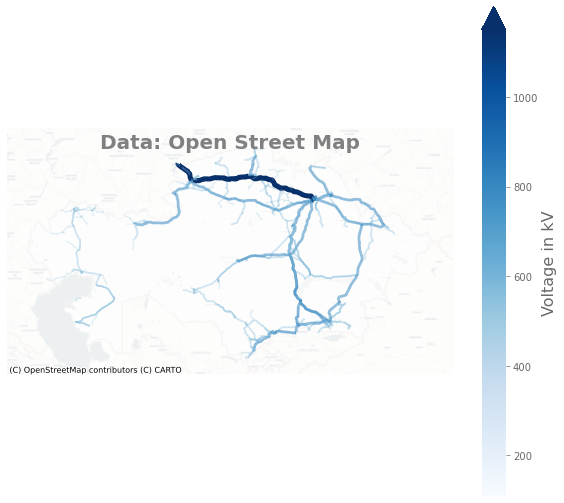

In [33]:
import contextily as cx  # Need to be installed `pip3 install contextily`
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl

# adapt all sizes
size = 0.5
# Create the basemap that is called by ax
ax = KZ_shape.to_crs(epsg="3857").plot(
    figsize=(20 * size, 20 * size), alpha=0.5, facecolor="white", edgecolor="whitesmoke"
)

# Create open street map background map
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.4)

# Create open street map background map
df = df_lines_clean_osm_KZ[df_lines_clean_osm_KZ.country == "KZ"]
df = df_lines_clean_osm_KZ[df_lines_clean_osm_KZ.voltage >= 110000]

# Scale and format stuff
blues = cm.get_cmap("Blues")
dfact = 0.28  # impacts min-max differences of weight, transparency and color
widthscale = 10 * size
df["normalized_v"] = (1 - dfact) * (df["voltage"] - df["voltage"].min()) / (
    df["voltage"].max() - df["voltage"].min()
) + dfact
line = df
normalized_voltage = df.normalized_v

line.plot(
    ax=ax,
    alpha=normalized_voltage,
    linewidth=normalized_voltage * widthscale,
    color=blues(normalized_voltage + 0.1),
    legend=True,
)
ax.set_title(
    "Data: Open Street Map",
    fontsize=40 * size,
    y=1.0,
    pad=-40 * size,
    fontweight="bold",
    color="grey",
)
ax.set_axis_off()

# Colorbar
cmap = blues
norm = mpl.colors.Normalize(
    vmin=df["voltage"].min() / 1000, vmax=df["voltage"].max() / 1000
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    extend="max",
    shrink=0.9,
)
cbar.set_label("Voltage in kV", fontsize=16, color="dimgrey")
# ticks & edge modification of cbar
cbar.ax.yaxis.set_tick_params(color="grey")
plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color="dimgrey")
cbar.outline.set_edgecolor(None)  # set colorbar edgecolor

plt.savefig("KZ-network-comparison-osm.pdf", bbox_inches='tight')

#### WBD for Kazakhstan

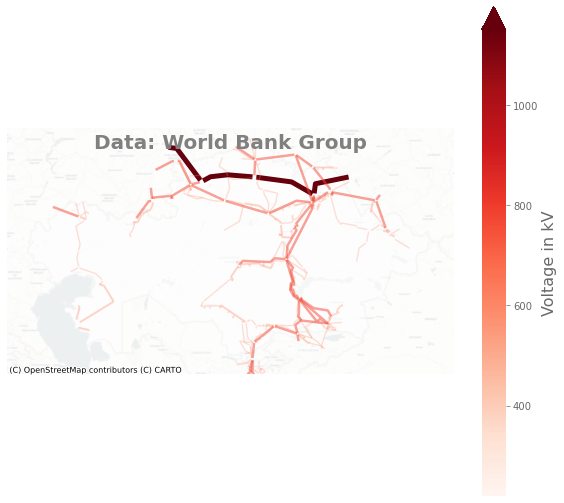

In [35]:
from matplotlib import cm
import contextily as cx  # Need to be installed `pip3 install contextily`

# adapt all sizes
size = 0.5
# Create the basemap that is called by ax
ax = KZ_shape.to_crs(epsg="3857").plot(
    figsize=(20 * size, 20 * size), alpha=0.5, facecolor="white", edgecolor="whitesmoke"
)

# Create open street map background map
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.4)

# Create open street map background map
df = df_lines_world_bank_existing[df_lines_world_bank_existing.voltage_kV >= 110]

# Scale and format stuff
reds = cm.get_cmap("Reds")
dfact = 0.28  # impacts min-max differences of weight, transparency and color
widthscale = 10 * size
df["normalized_v"] = (1 - dfact) * (df["voltage_kV"] - df["voltage_kV"].min()) / (
    df["voltage_kV"].max() - df["voltage_kV"].min()
) + dfact
line = df
normalized_voltage = df.normalized_v

line.plot(
    ax=ax,
    alpha=normalized_voltage,
    linewidth=normalized_voltage * widthscale,
    color=reds(normalized_voltage + 0.1),
)
ax.set_title(
    "Data: World Bank Group",
    fontsize=40 * size,
    y=1.0,
    pad=-40 * size,
    fontweight="bold",
    color="grey",
)
ax.set_axis_off()

# Colorbar
cmap = reds
norm = mpl.colors.Normalize(vmin=df["voltage_kV"].min(), vmax=df["voltage_kV"].max())
# ticks = np.linspace(df["voltage_kV"].min(), df["voltage_kV"].max(), 100, endpoint=True)

cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    extend="max",
    shrink=0.9,
)
cbar.set_label("Voltage in kV", fontsize=16, color="dimgrey")
# ticks & edge modification of cbar
cbar.ax.yaxis.set_tick_params(color="grey")
plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color="dimgrey")
cbar.outline.set_edgecolor(None)  # set colorbar edgecolor

plt.savefig("KZ-network-comparison-worldbank.pdf", bbox_inches='tight')

### 2) Plot for Kazakhstan and Central Asia (with voltage class distribution) 

### Plot for Kazakhstan

In [36]:
import seaborn as sns

coords_tol = 0.5
regions_list = "KZ"   # Choose the country you want to focus

# choose the option to get your plot
# data_type = "clean"
data_type = "raw"

if data_type == "raw":
        lines_ODD_path = os.path.realpath("resources/osm/raw") + "/" + regions_list + "_all_raw_lines.geojson" 
        lines_df = gpd.read_file(lines_ODD_path)       
        lines_df.rename(columns={"tags.voltage": "voltage"}, errors="raise", inplace=True)
        lines_df.rename(columns={"tags.circuits": "circuits"}, errors="raise", inplace=True)
else: 
        lines_ODD_path = os.path.realpath("resources/osm/clean") + "/" + regions_list + "_all_lines.geojson"     
        lines_df = gpd.read_file(lines_ODD_path)
        lines_df.rename(columns={"voltage": "voltage"}, errors="raise", inplace=True)
        lines_df.rename(columns={"circuits": "circuits"}, errors="raise", inplace=True)

Modified bounds:
[46.186110300000095, 40.331178100000045, 86.77087300000119, 56.65614639999996]


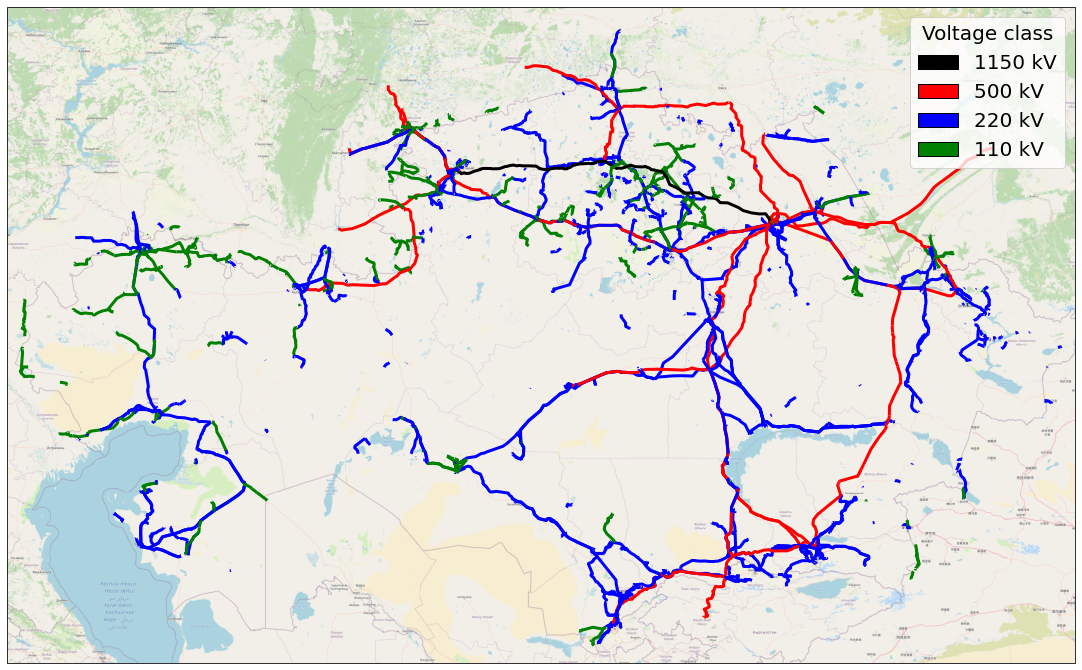

In [37]:
    # print(lines_df.columns)

    bounds_mod = [
        lines_df["geometry"].bounds["minx"].min() - coords_tol,
        lines_df["geometry"].bounds["miny"].min() - coords_tol,
        lines_df["geometry"].bounds["maxx"].max() + coords_tol,
        lines_df["geometry"].bounds["maxy"].max() + coords_tol,
    ]

    print("Modified bounds:")
    print(bounds_mod)
    
    # reorder bounds to comply with extend function (x0, x1, y0, y1)
    extent_list = (bounds_mod[0], bounds_mod[2], bounds_mod[1], bounds_mod[3])
    
    # get the structure of the background data to plot
    imagery = OSM()
    
    max_width = 30  # max width of the figure
    max_height = 30  # max heifht of the figure
    
    # calculate figure size with appropriate multiplier to adhere to the desired width/height
    multiplier = min(max_width/(extent_list[1] - extent_list[0]), max_height/(extent_list[3] - extent_list[2]))
    figsize=((extent_list[1] - extent_list[0])*multiplier, (extent_list[3] - extent_list[2])*multiplier)
    
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)  # specify projection
    ax.set_extent(extent_list, ccrs.PlateCarree())  # specify the location of the image
    ax.add_image(imagery, 7)  # add the background image
    
    # create an auxiliary dataframe for the substations with the desired crs and color properties
    df_osm_plot = lines_df.to_crs(imagery.crs)
    
    # create an auxiliary dataframe for the lines with the desired crs and properties
    df_line_plot = lines_df.to_crs(imagery.crs)
    #df_line_plot["centroids"] = df_line_plot.geometry.boundary.centroid  # get the centroids of the line

    def voltage_to_color(v):
        if isinstance(v, type(None)):
            return("blue")
        if float(v) >= 1150000:   
            return("black")
        if float(v) >= 500000:   
            return("red")
        if float(v) >= 220000:   
            return("blue")
        else:
            return("green")       

    df_line_plot["color"] = df_line_plot.voltage.apply(lambda x: voltage_to_color(x))  # specify the color of the line
       
    # draw the lines
    df_line_plot.plot(
        color=df_line_plot.color,
        linewidth=3,
        ax=ax
    )   

    labels = ['1150 kV', '500 kV', '220 kV', '110 kV']
    patch1 = mpatches.Patch(facecolor='black', edgecolor='#000000') 
    patch2 = mpatches.Patch(facecolor='red', edgecolor='#000000')
    patch3 = mpatches.Patch(facecolor='blue', edgecolor='#000000')
    patch4 = mpatches.Patch(facecolor='green', edgecolor='#000000')
    plt.legend(handles = [patch1, patch2, patch3, patch4], labels=labels,
       loc="upper right", title="Voltage class", title_fontsize=20, fontsize=20)
    plt.subplots_adjust()

    plt.savefig(regions_list + '_lines_' + data_type + '.jpeg', dpi=300)

# Conclusion 

1. According to the results of the analysis of the WBD and OSM data , the following results were obtained:
  - Overhead transmission lines of 500 kV voltage class connecting Kazakhstan with Russia are displayed according to the WBD map, but not according to the OSM maps. This is due to the limitation of the territory when building the map according to OpenStreetMap data. This point should be corrected when building a map for the whole of Central Asia.
  - There are no 220 kV lines between Agadir (Tsentralnye mes) and Aktogai (Vostochnye mes) according to WBD data. This is due to the fact that the lines of this area were built after 2016. A similar situation is observed for 220 kV voltage class lines between Ekibastuzskaya (Severnye mes) and Semey (Vostochnye mes).
  - There is no line with a voltage class of 1150 kV in the north-east of the country, this is due to the fact that this line according to WBD borders with Russia, while the map according to OSM is being built only on the territory of Kazakhstan.
  - The received maps according to the data of WBD and OSM coincide with the maps of the electrical networks of Kazakhstan from the official source - KEGOC.
  
2. According to the electric network maps for Kazakhstan and Central Asia by voltage class distribution, the absence of 1150 kV lines was obtained (for both cases). Therefore, according to the line ID data (from [map of electrical networks of the Republic of Kazakhstan](https://www.kegoc.kz/upload/iblock/e2f/s9m8xjeia620dr16qo94dxn5lisd4rso.pdf)), the lines corresponding to 1150 kV were determined, and the voltage class in the source data was changed for them. 

! Important note: 1150 kV lines are normally operated as 500 kV lines.

3. When analyzing the electrical networks maps by voltage class distribution, the following conclusions were obtained:
  - Distribution of backbone lines (330 kV and above) for Kazakhstan and for Kazakhstan as part of Central Asia exactly repeats the data of the system operator.  
  - A similar situation is observed for 220 kV supply networks. However, there are two sections on which the lines take the values of 220 kV, but according to the Kazakhstan network operator, they have a voltage class of 110 kV. These are lines with ID:
      - 200987707_0
      - 471124850_0
      - 657082600_0
  - There are no sections of lines in the clean data that are not connected to the general network, but the distribution of 220 kV and higher lines is completely preserved.
  - The network map built according to OSM data repeats the system operator's map well for 220 kV and higher lines, but in some areas there is no distribution of 110 kV lines. The absence of the most significant 110 kV lines is shown below:


![Comparison](comparison.gif)

Final conclusion: quite realistic maps are built according to Open Street Map data.